In [1]:
import argparse
from operator import imod
import os
import sys
import numpy as np
from numpy.lib.nanfunctions import _nancumprod_dispatcher

from warmup_scheduler import scheduler

PROJECT_ROOT = '/Users/dmitry/Documents/Personal/study/kaggle/tantum'
sys.path.append(PROJECT_ROOT)

import glob
import albumentations
import pandas as pd
import tantum
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from sklearn import metrics, model_selection, preprocessing
from torchvision.datasets import STL10
import matplotlib.pyplot as plt
import IPython.display as display
import time

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from tantum.callbacks import EarlyStopping, OutOfFold, WeightAndBiasesCallback, Checkpoint, PlotErrAcc
from tantum.datasets.datasets import ImageDataset
from tantum.trainer.v1.base_fitter import Model
from torch.nn import functional as F
from tantum.model.simple_net import Net
from tantum.datasets.datasets import create_folds, MnistDataset
from tantum.enums import ModelState, TrainingState

from tantum.datasets.augmentations import cutmix, mixup, fmix
from tantum.model.attention.multihead import MultiHeadAttention

from tantum.model import get_model
from tantum.optimizer import get_optimizer
from tantum.loss import get_criterion
from tantum.scheduler import get_scheduler

INPUT_PATH = "../../../input"
MODEL_PATH = "../models/"
# MODEL_NAME = os.path.basename(__file__)[:-3]
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
IMAGE_SIZE = 192
EPOCHS = 20


In [2]:

class Config:
    # target_size=10
    model_type='Net'
    optim='AdamW'
    criterion='CrossEntropyLoss'
    scheduler='CosineAnnealingWarmRestarts'
    
    
    scheduler_params={'T_0':10, "last_epoch":-1, 'eta_min':1e-4, "T_mult":1}
    model_params = {'target_size': 10}
    use_cutmix=False


In [3]:

def plot_without_attention(tr_err, ts_err, tr_acc, ts_acc, img):
    plt.clf()
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].plot(tr_err, label='tr_err')
    axs[0].plot(ts_err, label='ts_err')
    axs[0].legend()
    axs[1].plot(tr_acc, label='tr_err')
    axs[1].plot(ts_acc, label='ts_err')
    axs[1].legend()
    axs[2].axis('off')
    axs[3].axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

def plot_with_attention(img, att_out, no_images=6):
    print(img.shape)
    plt.clf()
    fig, axs = plt.subplots(1+no_images, 4, figsize=(20, (no_images+1)*5))
#     axs[0, 0].plot(tr_err, label='tr_err')
#     axs[0, 0].plot(ts_err, label='ts_err')
#     axs[0, 0].legend()
#     axs[0, 1].plot(tr_acc, label='tr_err')
#     axs[0, 1].plot(ts_acc, label='ts_err')
#     axs[0, 1].legend()
#     axs[0, 2].axis('off')
#     axs[0, 3].axis('off')
    for img_no in range(6):
#         print(img.shape)
        im = img[img_no].cpu().detach().numpy()
        axs[img_no+1, 0].imshow(im)
        for i in range(3):
            att_out_img = att_out[img_no, i+1].cpu().detach().numpy()
            axs[img_no+1, i+1].imshow(att_out_img)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)


In [4]:

class ConvPart(nn.Module):
    def __init__(self):
        super(ConvPart, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        

    def forward(self, x):
        x = x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        return x


class NetMultiheadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = ConvPart()
        self.attn1 = MultiHeadAttention(n_head=4, d_model=20, d_k=8, d_v=8)
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-4)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.final = nn.Linear(20,10)

    def forward(self, x):
        z = self.conv(x)
        q = torch.reshape(z, (z.size(0), -1 , z.size(1)))
        q, w = self.attn1(q, q, q)
        q = torch.reshape(q, (z.size(0), z.size(1), z.size(2), z.size(3)))
        z = q.mean(3).mean(2)
        z = q.view(-1, 320)
        z = self.fc1(z)
        z = self.fc2(z)
        return F.log_softmax(z, -1), q


class MnistModel(Model):
    def __init__(self):
        super().__init__()
        # self.model = get_model(Config)()
        self.model = NetMultiheadAttention()
        self.opt = get_optimizer(Config)(self.parameters(), lr=1e-4)
        self.loss_fn = get_criterion(Config)()
        
        self.input = None
        self.attention = None 
        
    
    def monitor_metrics(self, outputs, targets):
        outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, outputs)
        return {"accuracy": accuracy}

    def fetch_scheduler(self, train_loader):
        scheduler = get_scheduler(Config)(self.opt, **Config.scheduler_params)
        return scheduler

    def fetch_optimizer(self):
        return self.opt

    def forward(self, image, targets=None):
        mix_decision = np.random.rand()
        image = image.float()
        targets = targets.long()
        if Config.use_cutmix and mix_decision < 0.25:
            image, image_labels = cutmix(image, targets, 1.)
        # elif mix_decision >=0.25 and mix_decision < 0.5:
            # image, image_labels = fmix(image, targets, alpha=1., decay_power=5., shape=(28,28))
            
        outputs, att = self.model(image.float())
        
        self.input = image
        self.attention = att
        
        if targets is not None:
            
            if Config.use_cutmix and mix_decision < 0.25:
                loss = self.loss_fn(outputs, image_labels[0]) * image_labels[2] + self.loss_fn(outputs, image_labels[1]) * (1. - image_labels[2])
                metrics = self.monitor_metrics(outputs, image_labels[0])
                return outputs, loss, metrics
            else:
                loss = self.loss_fn(outputs, targets)
                metrics = self.monitor_metrics(outputs, targets)
            
            
                
            return outputs, loss, metrics
        return outputs, 0, {}

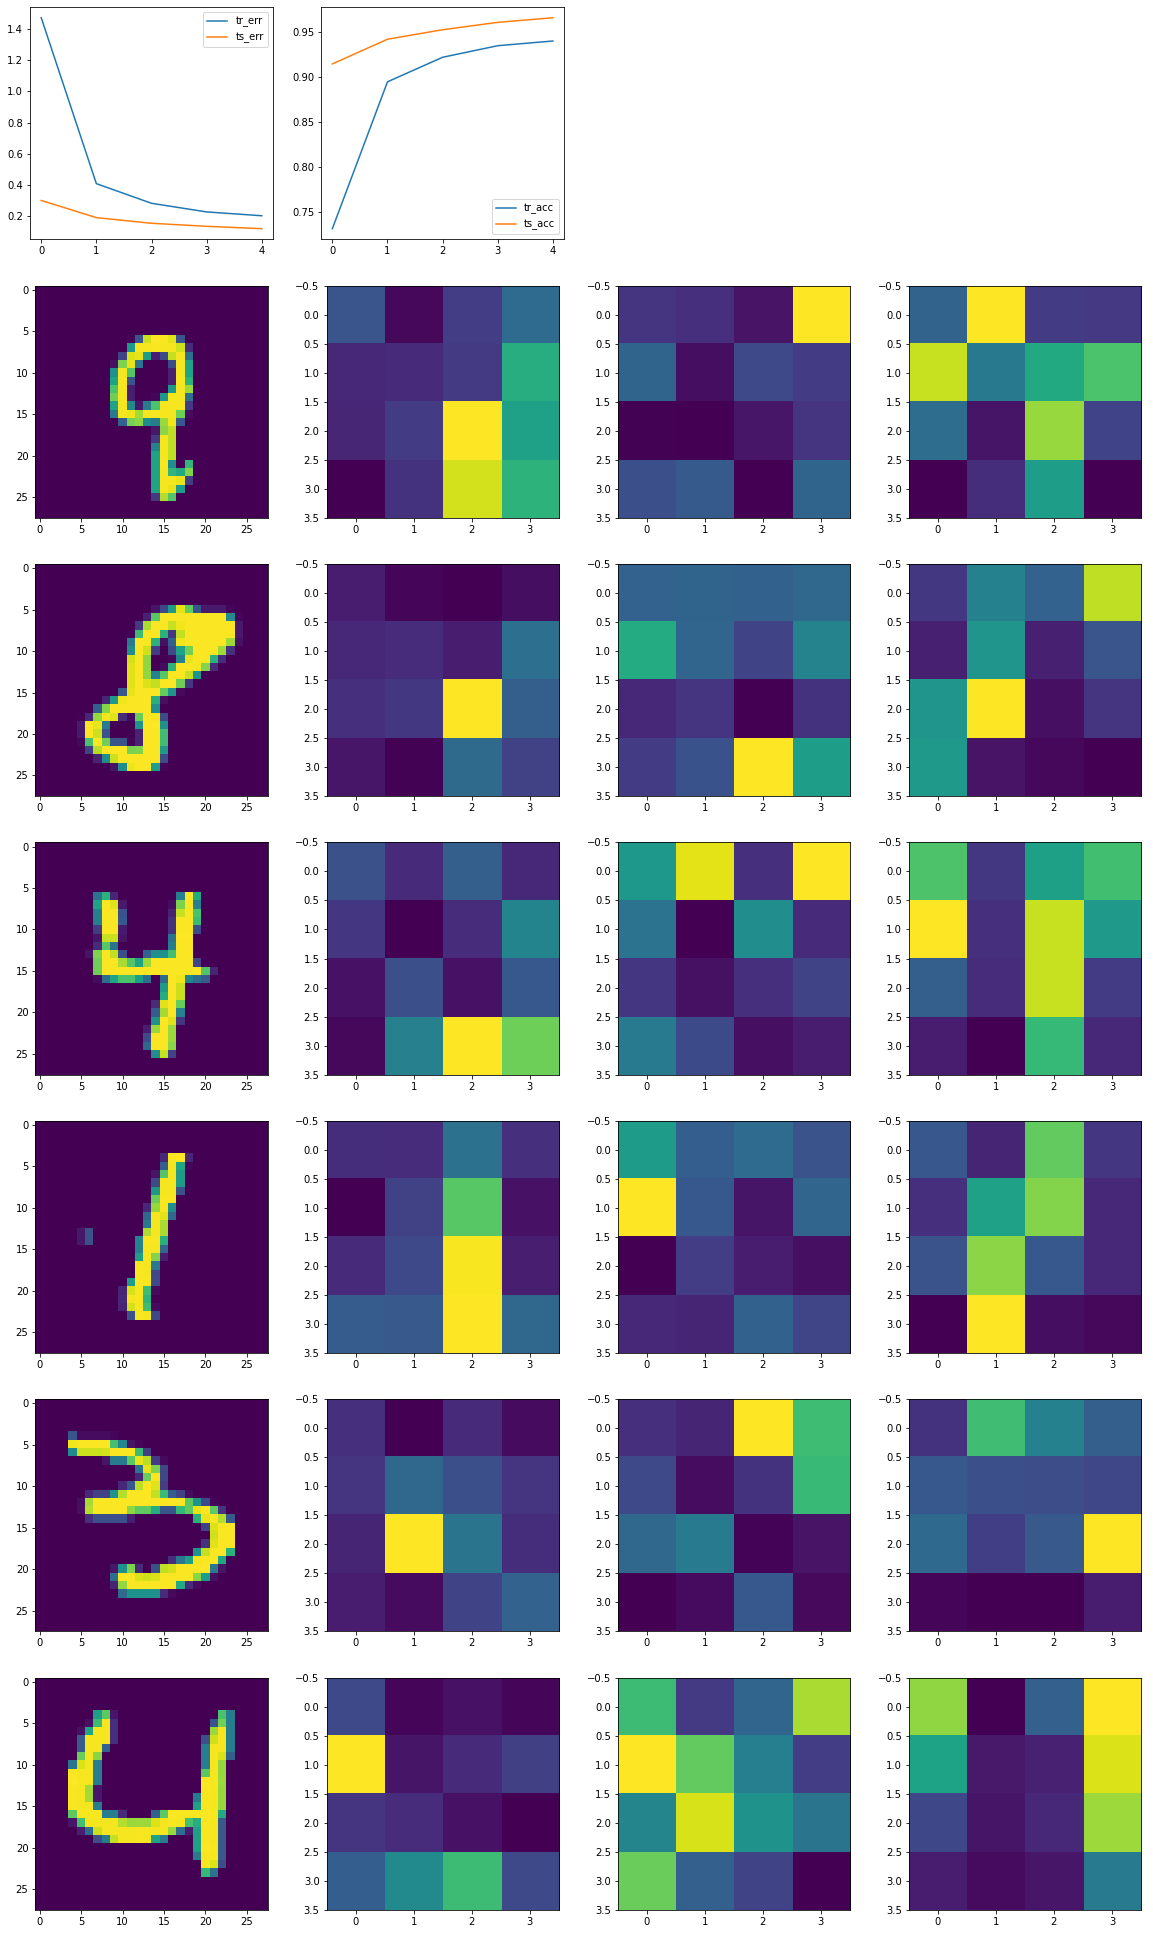

Train Epoch 5:  36%|███▋      | 381/1050 [00:15<00:26, 24.86it/s, accuracy=0.942, loss=0.18, stage=train] 


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

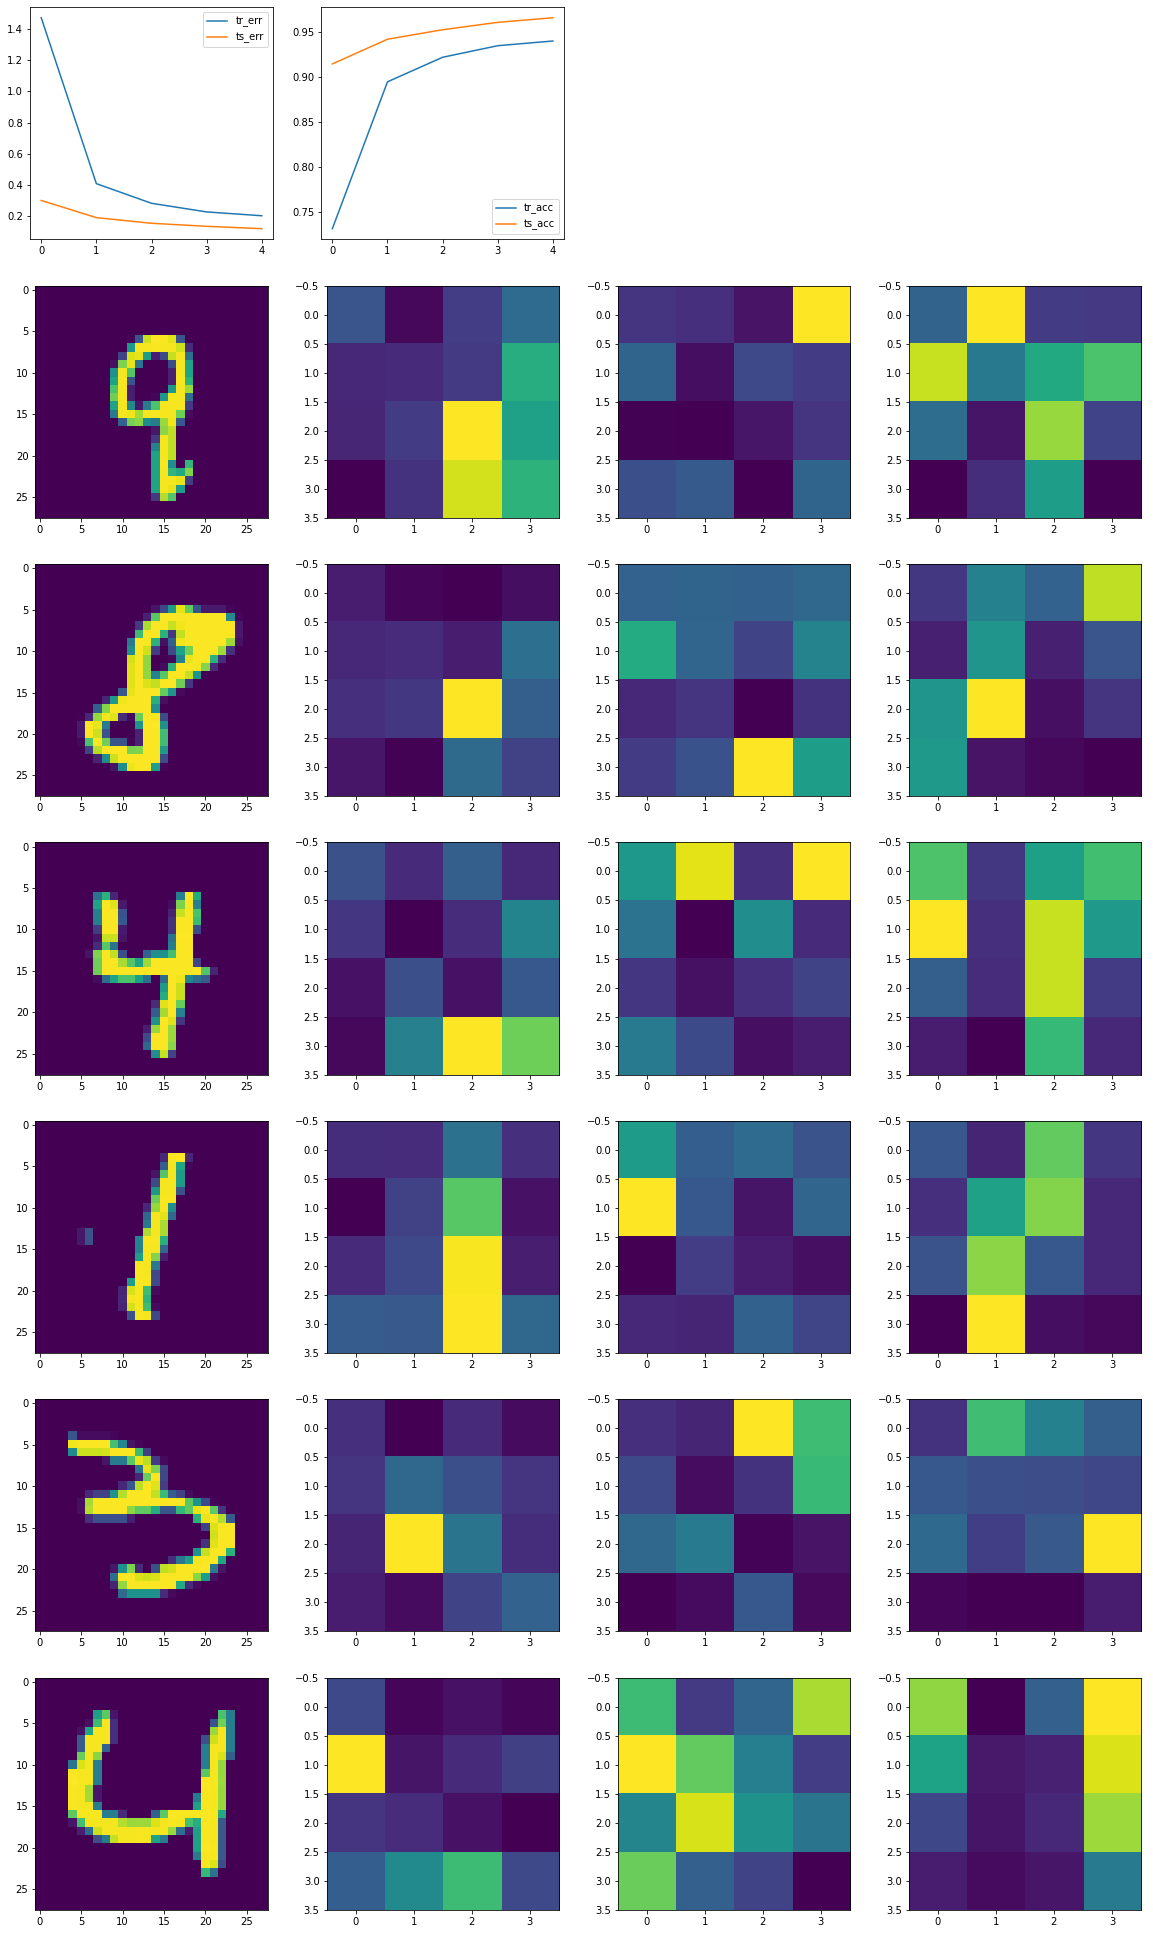

In [5]:
if __name__ == "__main__":


    ## Reading Data
    df = pd.read_csv(os.path.join(PROJECT_ROOT, 'train.csv') )
    ## Create Folds
    folds = create_folds(df, 5)

    ## Callbacks 

    oof_callback = OutOfFold(output_path='./')
    
    es_callback = EarlyStopping(
        monitor="valid_loss",
        model_path=os.path.join('./', 'mnist' + ".pt"),
        patience=3,
        mode="min",
    )

    chc_callback = Checkpoint(save_path='./', file_name='mnist_checkpoint')
    plot_callback = PlotErrAcc(attention_show=True)

    # wb_callback = WeightAndBiasesCallback(project='mnist')

    for fold in range(5):

        model = MnistModel()

        trn_idx = folds[folds['fold'] != fold].index
        val_idx = folds[folds['fold'] == fold].index

        train_folds = folds.loc[trn_idx].reset_index(drop=True)
        valid_folds = folds.loc[val_idx].reset_index(drop=True)

        y = train_folds['label'].values
        X = train_folds.drop(['label','fold'], axis=1).values

        y_val = valid_folds['label'].values
        X_val = valid_folds.drop(['label','fold'], axis=1).values

        
        valid_labels = valid_folds['label'].values
        
        train_dataset = MnistDataset(
            X = X,
            y = y,
        )

        valid_dataset = MnistDataset(
            X = X_val,
            y = y_val,
        )

        model.fit(
            train_dataset,
            valid_dataset=valid_dataset,
            train_bs=TRAIN_BATCH_SIZE,
            valid_bs=VALID_BATCH_SIZE,
            device="cpu",
            epochs=EPOCHS,
            callbacks=[plot_callback],
            fp16=False,
            n_jobs=0,
            valid_labels=valid_labels,
            valid_folds=valid_folds,
            target_size=10,
            fold=fold
        )